In [21]:
# Simulation for a colloidal particle in water at room temperature.
import math
import numpy as np 
import matplotlib.pyplot as plt

R = 1e-6  # Radius of the Brownian particle [m].
eta = 1e-3  # Viscosity of the medium.
gamma = 6 * np.pi * R * eta  # Drag coefficient of the medium. 
kBT = 4.11e-21  # kB*T at room temperature [J].
D = kBT / gamma  # Diffusion constant [m^2 / s].

In [22]:
import math
import numpy as np 
import matplotlib.pyplot as plt

def tMSD_2d(x,y,L):
    """
    Function to calculate the tMSD.
    
    Parameters
    ==========
    x : Trajectory (x component).
    y : Trajectory (x component).
    L : Indicates the maximum delay (L * dt) considered.
    """

    tmsd = np.zeros(L)
    
    nelem = np.size(x)

    for n in range(L):
        Nmax = nelem - n
        dx = x[n:nelem] -  x[0: Nmax]
        dy = y[n:nelem] -  y[0: Nmax]
        tmsd[n] += np.mean((dx ** 2) + (dy**2))

    return tmsd

In [23]:
def eMSD_2d(x, y):
    """
    Compute ensemble-averaged MSD in 2D, relative to the starting point.

    Parameters
    ----------
    x : ndarray, shape (N_traj, N_steps)
        Trajectories (x component).
    y : ndarray, shape (N_traj, N_steps)
        Trajectories (y component).

    Returns
    -------
    emsd : ndarray, shape (N_steps,)
        Ensemble-averaged MSD vs. time, measured from the initial position.
    """
    N_traj, N_steps = x.shape

    # subtract initial position using broadcasting
    dx = x - x[:, [0]]   # shape (N_traj, N_steps)
    dy = y - y[:, [0]]   # shape (N_traj, N_steps)

    # squared displacement
    disp2 = dx**2 + dy**2

    # average over trajectories
    emsd = np.mean(disp2, axis=0)

    return emsd


The code for the harmonic trap

In [24]:
import numpy as np
k = 1e-6  # Trapping stiffness [N/m].

dt = 1e-3  # Time step [s]. For viscous simulation.

# Coefficients for the finite difference solution.
c_noise = np.sqrt(2 * D * dt)
c_trap = k / gamma * dt

# Simulation for tMSD. Long trajectory with 1e+6 points.
N_steps_t = int(1e+6)
duration_t = N_steps_t * dt  # Total time [s].

# Simulation for eMSD. 1e+3 trajectories with 1e+3 points each.
N_steps_e = int(1e+3)
duration_e = N_steps_e * dt  # Total time [s].
N_traj = 1000

x0 = 0  # Initial position [m].
y0 = 0  # Initial position [m].

# Generate long trajectory for time average.

x_t = np.zeros(N_steps_t)
y_t = np.zeros(N_steps_t)
rn_t_x = np.random.normal(0, 1, N_steps_t)
rn_t_y = np.random.normal(0, 1, N_steps_t)

x_t[0] = x0

for n in range(N_steps_t - 1):
    x_t[n + 1] = x_t[n] - c_trap * x_t[n] + c_noise * rn_t_x[n]

y_t[0] = y0

for n in range(N_steps_t - 1):
    y_t[n + 1] = y_t[n] - c_trap * y_t[n] + c_noise * rn_t_y[n]

# Build the time dependence.
t_t = dt * np.arange(N_steps_t)

# Calculate tMSD
tmsd = tMSD_2d(x_t,y_t, L=N_steps_e)  # Note: L=N_steps_e.

# Define the time dependence for tMSD (and later eMSD)
t_delay = dt * np.arange(N_steps_e)

Plot time dependence of x (t), y(t) tMSD

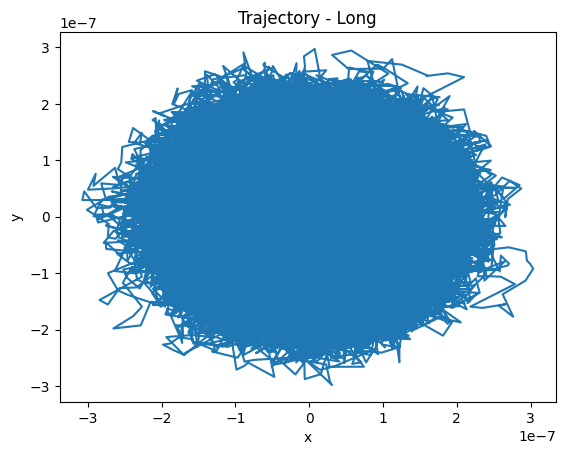

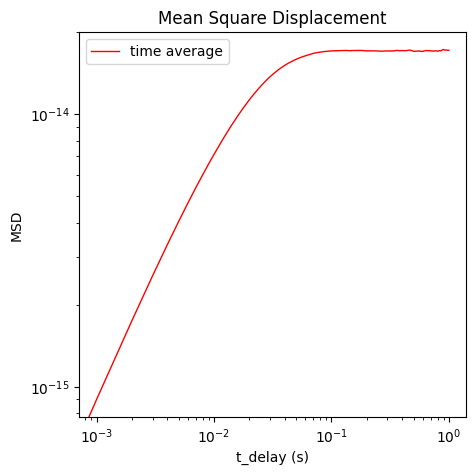

In [25]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x_t,y_t)
plt.title('Trajectory - Long')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


plt.figure(figsize=(5,5))
plt.loglog(t_delay, tmsd, '-', color='r', linewidth=1, 
         label='time average')
plt.legend()
plt.title('Mean Square Displacement')
plt.xlabel('t_delay (s)')
plt.ylabel('MSD')
plt.show()

Now generate ensemble trajectories by allowing thermalization. Let the system thermalize for a time t0

In [6]:
import numpy as np

x0 = 0  # Initial position [m].

# We must let the system to termalize a bit each time.
N_steps_thermalization = 1000

# Generate N_traj trajectories for ensemble average.
x_e = np.zeros([N_traj, N_steps_e])
rn_e = np.random.normal(0, 1, size=(N_traj, N_steps_e))

for i in range(N_traj):
    # Thermalization cycle.
    x = x0
    rn_therm = np.random.normal(0, 1, N_steps_thermalization)
    for n in range(N_steps_thermalization - 1):
        x = x - c_trap * x + c_noise * rn_therm[n]
    # Starts from thermalized position.
    x_e[i, 0] = x  # 
    for n in range(N_steps_e - 1):
        x_e[i, n + 1] = x_e[i, n] - c_trap * x_e[i, n] + c_noise * rn_e[i, n]
    
# Build the time dependence.
t_e = dt * np.arange(N_steps_e)

# Calculate eMSD
emsd_therm = eMSD_2d(x_e)  # eMSD from ensemble trajectories.

NameError: name 'N_traj' is not defined

Plot time dependence and eMSD for the thermalized trajectories.

In [9]:
plt.figure()
for i in range(N_traj):
    plt.plot(t_e, x_e[i, :])
plt.title('Trajectories - Ensemble')
plt.xlabel('t (s)')
plt.ylabel('x')
plt.show()

plt.figure(figsize=(5,5))
plt.loglog(t_delay, emsd_therm, '-', color='g', linewidth=1, 
         label='ensemble average')
plt.legend()
plt.title('Mean Square Displacement')
plt.xlabel('t_delay (s)')
plt.ylabel('MSD')
plt.show()

NameError: name 'plt' is not defined

Plot and compare tMSD and eMSD for thermalized eMSD

In [8]:
plt.figure(figsize=(5,5))
plt.loglog(t_delay, tmsd, '-', color='r', linewidth=1, 
         label='time average')
plt.loglog(t_delay, emsd_therm, '-', color='g', linewidth=2, 
         label='ensemble average (therm. start pos.) ')
plt.legend()
plt.xlabel('t_delay (s)')
plt.ylabel('MSD')
plt.show()

NameError: name 'plt' is not defined